In [2]:
#TRAINING FILE

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import joblib
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import timedelta

In [3]:
 training_data_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\train.csv"
   

In [4]:

def load_data(file_path):
    print("Loading data...")
    try:
        # Load your dataset using pandas or any other suitable library
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print(f"Error loading the dataset: {str(e)}")
        sys.exit(1)

In [5]:
def preprocess_data(data):
    # Handle missing values
    data.fillna(0, inplace=True)  # You can choose another strategy based on your data

    # Convert the 'Date' column to datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Check for and handle outliers (you can customize this based on your dataset)
    weekly_sales_mean = data['Weekly_Sales'].mean()
    weekly_sales_std = data['Weekly_Sales'].std()
    lower_bound = weekly_sales_mean - 3 * weekly_sales_std
    upper_bound = weekly_sales_mean + 3 * weekly_sales_std

    data['Weekly_Sales'] = np.where(data['Weekly_Sales'] < lower_bound, weekly_sales_mean, data['Weekly_Sales'])
    data['Weekly_Sales'] = np.where(data['Weekly_Sales'] > upper_bound, weekly_sales_mean, data['Weekly_Sales'])

    return data


In [6]:
def explore_weekly_sales(merged_data):
    # Explore the statistical properties of the 'Weekly_Sales' column
    print("\nStatistical Properties of Weekly Sales:")
    print(data['Weekly_Sales'].describe())
    print("\nCorrelation with Other Variables:")
    print(data.corr()['Weekly_Sales'])

In [7]:
def time_series_decomposition(data):
    # Perform time series decomposition
    result = seasonal_decompose(data['Weekly_Sales'], model='additive', period=52)  # Adjust period based on your data

    # Plot the decomposed components
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(data['Weekly_Sales'], label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(result.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()



In [8]:
def feature_engineering(data):
    # Extract relevant features from the date
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day

    # Check if 'IsHoliday' is present in the dataset
    if 'IsHoliday' in data.columns:
        # Consider lag features (previous sales values) as predictors
        for i in range(1, 6):  # Adjust the range based on the desired number of lag features
            data[f'Weekly_Sales_Lag_{i}'] = data['Weekly_Sales'].shift(i)

    return data


def train_test_split_data(data):
    # Split the dataset into features (X) and target variable (y)
    #X = data.drop(columns=['Weekly_Sales', 'Date', 'IsHoliday'])
    #y = data['Weekly_Sales']
    X = data.drop(columns=['Weekly_Sales', 'Date', 'IsHoliday_x', 'IsHoliday_y'])
    y = data['Weekly_Sales']

    # Split the data into training and testing sets
    # Ensure that the training set includes sufficient historical data for model training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test

def determine_arima_order(y_train):
    # Plot ACF and PACF
    plot_acf(y_train, lags=20)
    plot_pacf(y_train, lags=20)
    plt.show()

    # Perform seasonal decomposition
    result = seasonal_decompose(y_train, model='additive', period=52)  # Assuming weekly seasonality
    result.plot()
    plt.show()



def evaluate_model(model, X_test, y_test):
    # Make predictions on the testing set
    y_pred = model.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, typ='levels')
    #y_pred = model.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, typ='levels')

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    #plt.plot(y_test, label='Actual')
    #plt.plot(y_pred, label='Predicted')
    plt.plot(y_test.index, y_test.values, label='Actual')  # Adjusted to use index and values
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title('ARIMA Model Evaluation')
    plt.xlabel('Time')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()

    # Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("\nModel Evaluation:")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    evaluation_results = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_pred
    }, index=y_test.index)

    # Save evaluation results to Excel
    #evaluation_results.to_excel("C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\evaluation_results.xlsx", index=False)

def forecast_future_sales(model, X, steps):
    # No forecasting, just create the future index
    last_date = X.index[-1]
    future_index = pd.date_range(start=last_date, periods=steps + 1, freq='W-FRI')[1:]

    # Plot only historical sales without forecasting
    plt.figure(figsize=(10, 6))
    plt.plot(X.index, X.values, label='Historical Sales')
    plt.title('Historical Sales Data')
    plt.xlabel('Time')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()

    # Create a DataFrame with placeholder values for forecast results
    forecast_results = pd.DataFrame(index=X.index.append(future_index[1:]))
    forecast_results['Historical_Sales'] = X.values
    forecast_results['Forecasted_Sales'] = np.full(len(forecast_results), np.nan)

    # Print the forecast results (with placeholder values)
    print("Forecast Results:")
    print(forecast_results)

    # Save forecast results to Excel (with placeholder values)
    forecast_results.to_excel("C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\forecast_results.xlsx", index=True)

    return future_index, np.full(steps, np.nan)


def visualize_results(actual, predicted, title="Sales Forecasting Results"):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual Sales', marker='o')
    plt.plot(predicted, label='Predicted Sales', marker='o')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()
    visualization_results = pd.DataFrame({
        'Actual_Sales': actual,
        'Predicted_Sales': predicted
    })
    # Save visualization results to Excel
    visualization_results.to_excel("C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\visualization_results.xlsx", index=False)


def train_arima_model(y_train ):
    # Fit ARIMA model
    order_to_use = (5, 1, 0)  

    model = ARIMA(y_train, order= order_to_use)  # Example order, tune as needed
    fitted_model = model.fit()

    # Save the trained model for future use
    #joblib.dump(fitted_model, "trained_arima_model.joblib")  # Change this path as needed
    joblib.dump(fitted_model, "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\trained_arima_model.joblib")

    print("ARIMA Model trained and saved.")
    
    return fitted_model


def load_new_features(file_path):
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print(f"Error loading the new features dataset: {str(e)}")
        sys.exit(1)




In [9]:
def load_stores_data(file_path):
    print("Loading stores data...")
    try:
        # Load your stores dataset using pandas or any other suitable library
        stores_data = pd.read_csv(file_path)
        return stores_data
    except Exception as e:
        print(f"Error loading the stores dataset: {str(e)}")
        sys.exit(1)


Using training data from: C:\Users\sahir\OneDrive - The University of Colorado Denver\Desktop\SEM TWO\ML\PROJECT\train.csv
Using new features data from: C:\Users\sahir\OneDrive - The University of Colorado Denver\Desktop\SEM TWO\ML\PROJECT\features.csv
Loading and preprocessing data...
Loading data...
Loading stores data...

Updated Dataset with Engineered Features:
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     2 2010-02-05      50605.27        False        42.31       2.572   
2      1     3 2010-02-05      13740.12        False        42.31       2.572   
3      1     4 2010-02-05      39954.04        False        42.31       2.572   
4      1     5 2010-02-05      32229.38        False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  ...  MarkDown5         CPI  Unemployment  \
0        0.0        0.0        0.0  ...        0.0  211.096358  

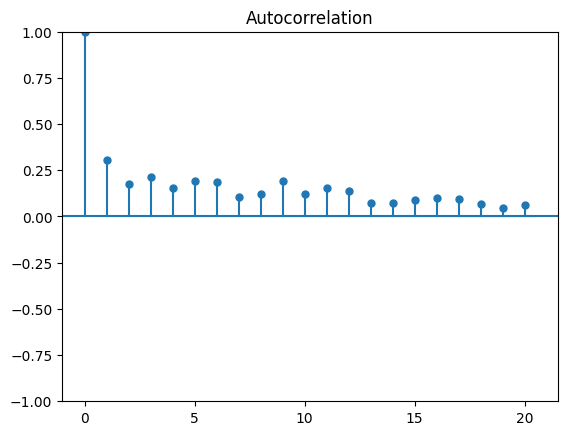

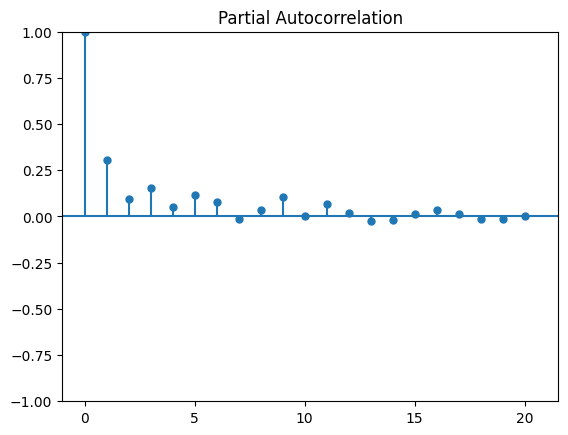

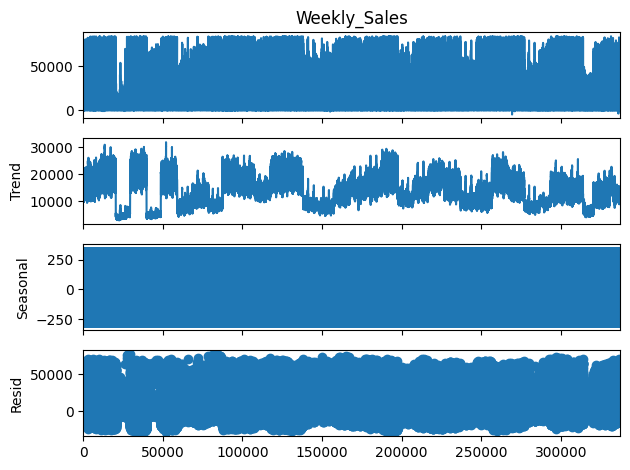

ARIMA Model trained and saved.


C:\Users\sahir\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


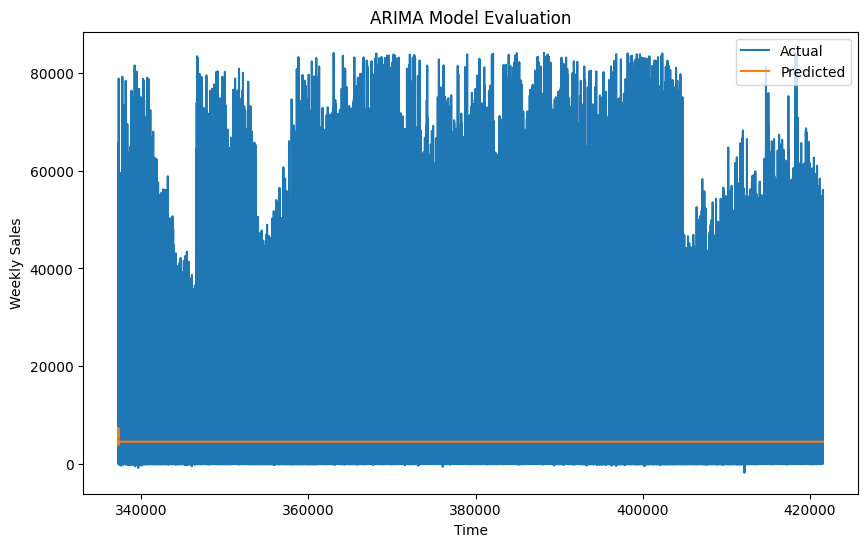


Model Evaluation:
Mean Squared Error (MSE): 299067597.27481097
Root Mean Squared Error (RMSE): 17293.57098099785


NameError: name 'order_to_use' is not defined

In [10]:
#updated

if __name__ == "__main__":
    # Get the path to the training dataset from the command line argument
    training_data_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\train.csv"
    new_features_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\features.csv"  # Replace with the actual path
    print(f"Using training data from: {training_data_path}")
    print(f"Using new features data from: {new_features_path}")
    print("Loading and preprocessing data...")
    data = load_data(training_data_path)
    new_features = load_new_features(new_features_path)
    stores_data = load_stores_data("C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\stores.csv")  # Replace with the actual path

    # Merge datasets based on common columns
    merged_data = pd.merge(data, new_features, on=['Store', 'Date'], how='inner')
    merged_data = pd.merge(merged_data, stores_data, on='Store', how='inner')

    # Feature Engineering
    merged_data['Date'] = pd.to_datetime(merged_data['Date'])
    merged_data['DayOfWeek'] = merged_data['Date'].dt.dayofweek
    merged_data['Month'] = merged_data['Date'].dt.month
    merged_data['Day'] = merged_data['Date'].dt.day
    merged_data.fillna(0, inplace=True)
    merged_data['IsHoliday'] = merged_data['IsHoliday_x'] | merged_data['IsHoliday_y']

    # Preprocess merged data
    merged_data = preprocess_data(merged_data)

    # Display the updated dataset with engineered features
    print("\nUpdated Dataset with Engineered Features:")
    print(merged_data.head())
    
    print("Time Series")

    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split_data(merged_data)

    # Display the shapes of the training and testing sets
    print("\nShapes of Training and Testing Sets:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("y_train:", y_train.shape)
    print("y_test:", y_test.shape)

    # Determining ARIMA order
    determine_arima_order(y_train)
    
    
    # Training ARIMA model
    trained_model = train_arima_model(y_train  )

    # Evaluating the model on the testing set
    evaluate_model(trained_model, X_test, y_test)

    # Forecasting future sales
    future_steps = 10
    #future_index, future_pred = forecast_future_sales(trained_model, y_train, future_steps)

    # Visualizing the results
    #print("Visualizing the results...")
    #visualize_results(y_test, future_pred, title="Sales Forecasting Results")
    
    
   # Example: Try different ARIMA orders
    print(f"\nTrying ARIMA Order: {order_to_use}")
    trained_model = train_arima_model(y_train)
    evaluate_model(trained_model, X_test, y_test)

# Make predictions on the testing set
    y_pred = trained_model.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, typ='levels')

# Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'ARIMA Model Evaluation - Order {order_to_use}')
    plt.xlabel('Time')
    plt.ylabel('Weekly Sales')
    plt.legend()

# Save the plot to an image file (e.g., PNG)
    plt.savefig(f"arima_evaluation_plot_order_{order_to_use}.png")

    plt.show()
            
    print("Program completed successfully.")


In [11]:
# Assuming 'test_data' is your test dataset
# Load the test dataset
test_data_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\test.csv"
test_data = pd.read_csv(test_data_path)
# Use the relevant columns as features in X_test
X_test = test_data[['Store', 'Dept', 'Date', 'IsHoliday']]

# Make predictions using the trained ARIMA model
y_pred_test = trained_model.predict(start=len(y_train), end=len(y_train) + len(X_test) - 1, typ='levels')
y_pred_test.index = test_data.index  # Align the index

# Add the predicted 'Weekly_Sales' to the test dataset
test_data['Predicted_Weekly_Sales'] = y_pred_test


C:\Users\sahir\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [12]:
print(y_pred_test.head())


0    5645.488568
1    7397.637277
2    3879.265080
3    4305.962897
4    4428.837188
Name: predicted_mean, dtype: float64


In [13]:
print(len(y_pred_test), len(test_data))


115064 115064


In [14]:
print(test_data[['Store', 'Dept', 'Date', 'IsHoliday', 'Predicted_Weekly_Sales']].head(5))


   Store  Dept        Date  IsHoliday  Predicted_Weekly_Sales
0      1     1  2012-11-02      False             5645.488568
1      1     1  2012-11-09      False             7397.637277
2      1     1  2012-11-16      False             3879.265080
3      1     1  2012-11-23       True             4305.962897
4      1     1  2012-11-30      False             4428.837188


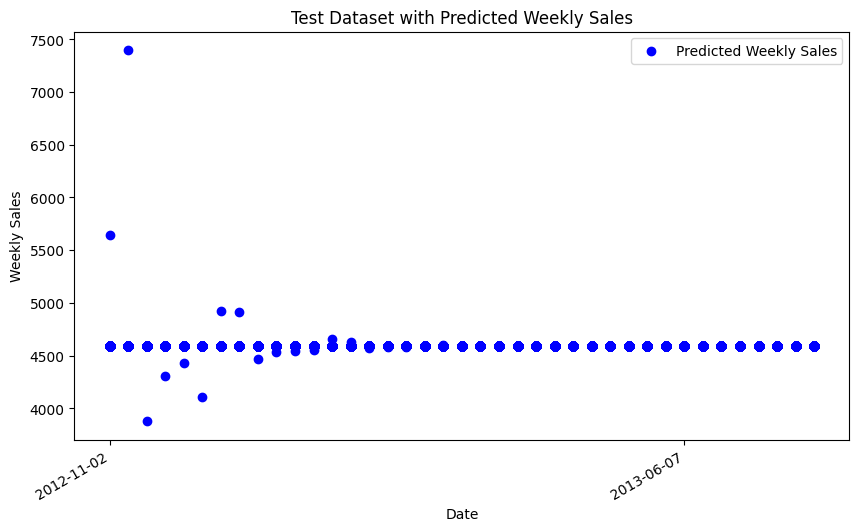

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming 'test_data' is your test dataset with predicted values
plt.figure(figsize=(10, 6))

# Use a scatter plot with markers
plt.scatter(test_data['Date'], test_data['Predicted_Weekly_Sales'], label='Predicted Weekly Sales', marker='o', color='blue')

# Customize the plot style
plt.title('Test Dataset with Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()

# Set the x-axis locator to show the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Save the plot to an image file (e.g., PNG)
plt.savefig("predicted_weekly_sales_plot.png")

# Save the DataFrame to an Excel file
output_excel_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\predicted_weekly_sales_data.xlsx"
test_data.to_excel(output_excel_path, index=False)

plt.show()


In [16]:
def CompareModels(data):
    features = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

    train_set=data[features + ['Weekly_Sales']]
    X_train, X_test, y_train, y_test = train_test_split(train_set[features], train_set['Weekly_Sales'], test_size=0.2,
                                                        random_state=42)
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Making predictions
    rf_preds = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, rf_preds)
    print("Random Forest - MAE :"+str(mae))
    rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    print("Random Forest - RMSE :"+str(rmse))
    accuracy = 1 - mae / np.mean(y_test)
    print("Random Forest - Accuracy : "+str(+accuracy*100)+"%")

    xgb_preds = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, xgb_preds)
    print("XGBoost - MAE :" + str(mae))
    rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
    print("XGBoost - RMSE :" + str(rmse))
    accuracy = 1 - mae / np.mean(y_test)
    print("XGBoost - Accuracy : " + str(accuracy*100)+"%")
    # Plotting results
    plt.figure(figsize=(14, 7))

    plt.plot(y_test.index, y_test.values, label='Actual Sales', color='black')
    plt.plot(y_test.index, rf_preds, label='Random Forest Predictions', color='blue')
    plt.plot(y_test.index, xgb_preds, label='XG Boost Predictions', color='red')

    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.title(f'Sales Prediction Comparison')
    plt.legend()
    plt.show()

#print("Comparing models")

#CompareModels(merge_df)

C:\Users\sahir\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


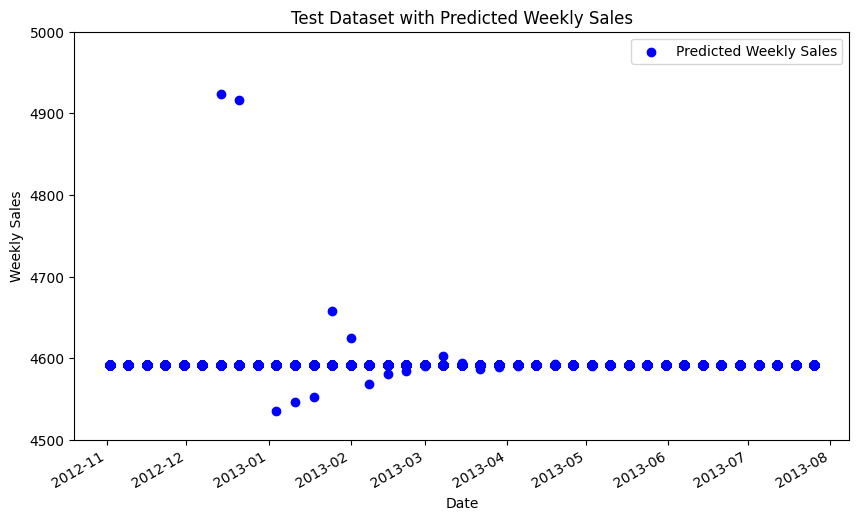

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming 'test_data' is your test dataset
# Load the test dataset
test_data_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\test.csv"
test_data = pd.read_csv(test_data_path)

# Convert the 'Date' column to datetime format
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Use the relevant columns as features in X_test
X_test = test_data[['Store', 'Dept', 'Date', 'IsHoliday']]

# Make predictions using the trained ARIMA model
y_pred_test = trained_model.predict(start=len(y_train), end=len(y_train) + len(X_test) - 1, typ='levels')
y_pred_test.index = test_data.index  # Align the index

# Add the predicted 'Weekly_Sales' to the test dataset
test_data['Predicted_Weekly_Sales'] = y_pred_test

# Set up the plot
plt.figure(figsize=(10, 6))

# Use a scatter plot with markers
plt.scatter(test_data['Date'], test_data['Predicted_Weekly_Sales'], label='Predicted Weekly Sales', marker='o', color='blue')

# Customize the plot style
plt.title('Test Dataset with Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()

# Set the x-axis locator to show the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()
plt.ylim(4500, 5000)

# Save the plot to an image file (e.g., PNG)
plt.savefig("predicted_weekly_sales_plot.png")

# Save the DataFrame to an Excel file
output_excel_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\predicted_weekly_sales_data.xlsx"
test_data.to_excel(output_excel_path, index=False)

plt.show()


C:\Users\sahir\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


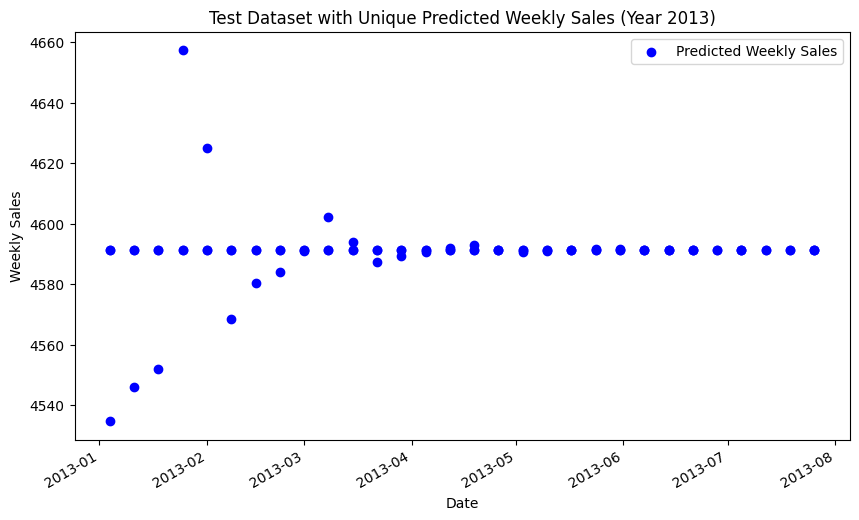

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Assuming 'test_data' is your test dataset
# Load the test dataset
test_data_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\test.csv"
test_data = pd.read_csv(test_data_path)

# Convert the 'Date' column to datetime format
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Use the relevant columns as features in X_test
X_test = test_data[['Store', 'Dept', 'Date', 'IsHoliday']]

# Make predictions using the trained ARIMA model
y_pred_test = trained_model.predict(start=len(y_train), end=len(y_train) + len(X_test) - 1, typ='levels')
y_pred_test.index = test_data.index  # Align the index


# Add the predicted 'Weekly_Sales' to the test dataset
test_data['Predicted_Weekly_Sales'] = y_pred_test

# Filter data for the year 2013
test_data_2013 = test_data[test_data['Date'].dt.year == 2013]

# Keep only unique rows based on 'Predicted_Weekly_Sales'
test_data_2013_unique = test_data_2013.drop_duplicates(subset='Predicted_Weekly_Sales')

# Set up the plot
plt.figure(figsize=(10, 6))

# Use a scatter plot with markers
plt.scatter(test_data_2013_unique['Date'], test_data_2013_unique['Predicted_Weekly_Sales'], label='Predicted Weekly Sales', marker='o', color='blue')

# Customize the plot style
plt.title('Test Dataset with Unique Predicted Weekly Sales (Year 2013)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()

# Set the x-axis locator to show the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Save the plot to an image file (e.g., PNG)
plt.savefig("unique_predicted_weekly_sales_plot_2013.png")

# Save the DataFrame to an Excel file
output_excel_path = "C:\\Users\\sahir\\OneDrive - The University of Colorado Denver\\Desktop\\SEM TWO\\ML\\PROJECT\\unique_predicted_weekly_sales_data_2013.xlsx"
test_data_2013_unique.to_excel(output_excel_path, index=False)

plt.show()


In [20]:
duplicate_dates = test_data[test_data.duplicated(subset='Date')]
print(duplicate_dates)


        Store  Dept       Date  IsHoliday  Predicted_Weekly_Sales
39          1     2 2012-11-02      False             4591.341087
40          1     2 2012-11-09      False             4591.348502
41          1     2 2012-11-16      False             4591.349943
42          1     2 2012-11-23       True             4591.344955
43          1     2 2012-11-30      False             4591.340108
...       ...   ...        ...        ...                     ...
115059     45    98 2013-06-28      False             4591.343482
115060     45    98 2013-07-05      False             4591.343482
115061     45    98 2013-07-12      False             4591.343482
115062     45    98 2013-07-19      False             4591.343482
115063     45    98 2013-07-26      False             4591.343482

[115025 rows x 5 columns]


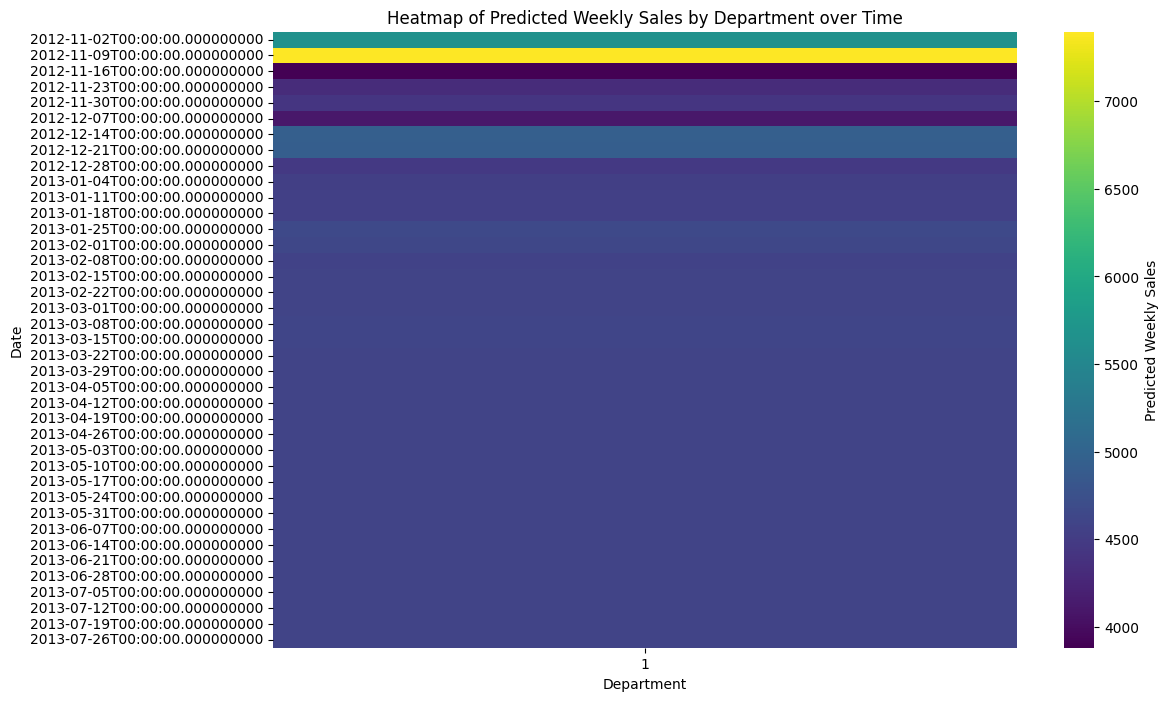

In [21]:
# Drop duplicate entries based on 'Date'
test_data = test_data.drop_duplicates(subset='Date', keep='first')

# Pivot the DataFrame for creating a heatmap
heatmap_data = test_data.pivot(index='Date', columns='Dept', values='Predicted_Weekly_Sales')

# Set up the plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Predicted Weekly Sales'})

plt.title('Heatmap of Predicted Weekly Sales by Department over Time')
plt.xlabel('Department')
plt.ylabel('Date')

plt.show()
